In [1]:
from utils.converters import df_to_XY
from utils.readers import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Read data
## Grouping M&A volume by month

In [2]:
def reconfigure_vol_df(df):
    df['Date'] = df['Date'].dt.to_period('M')
    out = {'date': [], 'vol': []}
    for y in range(2000, 2022):
        for m in range(1, 13):
            i = f"{y}-{m}"
            d = df[df['Date'] == i]
            out['date'].append(i)
            out['vol'].append(len(d))
    df = pd.DataFrame(data=out['vol'], index=out['date'], columns=['vol'])
    df.index.name = 'date'
    return df

In [3]:
"""Groups M&A transactions of UK being the acquirer by month"""
acquirer_uk = read_acquirer_uk()
acquirer_uk = reconfigure_vol_df(acquirer_uk)

In [4]:
"""Groups M&A transactions of UK being the target by month"""
target_uk= read_target_uk()
target_uk = reconfigure_vol_df(target_uk)

In [5]:
"""Net M&A volume"""
net_vol_monthly = target_uk + acquirer_uk

In [6]:
# net_vol_monthly.index.values.astype(str)

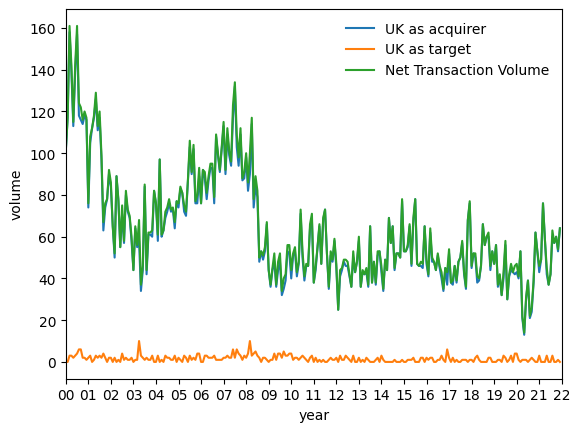

In [7]:
ax = plt.gca()
ax.plot(acquirer_uk.index.values.astype(str), acquirer_uk.vol, label='UK as acquirer')
ax.plot(target_uk.index.values.astype(str), target_uk.vol, label='UK as target')
ax.plot(net_vol_monthly.index.values.astype(str), net_vol_monthly.vol, label='Net Transaction Volume')
ax.set_xticks([])
ax.legend(frameon=False)
ax.set_xticks(ticks=range(0, 265, 12), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
ax.set_xlim(0, 264)
ax.set_ylabel('volume')
ax.set_xlabel('year');

## GDP

## Only quarterly data available

In [10]:
gdp_quarter = read_gdp()
until = '2022-01'
gdp_quarter['Date'] = gdp_quarter['Date'].dt.to_period('M')
gdp_quarter = gdp_quarter[gdp_quarter['Date'] < until]
# gdp_quarter

In [11]:
"""Regrouping transactions by cumulative of 3 months and quarterly data of other explanatory variables: SMI, EXUSUK, and SMI."""
res = []
for i in range(int(len(net_vol_monthly)/3)):
    s = net_vol_monthly[3*i: 3*(i+1)]
    res.append(s.vol.sum())
gdp_quarter['vol'] = res
# gdp_quarter

## Variables

In [12]:
until = '2022-01'
var_monthly = read_variable_monthly()
var_monthly['Date'] = var_monthly['Date'].dt.to_period('M')
var_monthly = var_monthly[var_monthly['Date'] < until]
var_monthly['vol'] = net_vol_monthly.vol.values

res = {'EXUSUK': [], 'Interest_Rate': [], 'SMI': []}
for i in range(int(len(var_monthly)/3)):
    s = var_monthly[3*i: 3*(i+1)]
    res['EXUSUK'].append(s.EXUSUK.mean())
    res['Interest_Rate'].append(s['Interest_Rate'].mean())
    res['SMI'].append(s.SMI.mean())
gdp_quarter['EXUSUK'] = res['EXUSUK']
gdp_quarter['Interest_Rate'] = res['Interest_Rate']
gdp_quarter['SMI'] = res['SMI']
# gdp_quarter

# Regression

In [40]:
"""To determine the effect the Brexit, we refer to the day of UK announcing its plan to exit the European Union as the separation date"""

x_index = ['EXUSUK', 'Interest_Rate', 'SMI']
y_index = ['vol']

start_from = '2001-08'
data = var_monthly[var_monthly.Date >= start_from]
data.reset_index(inplace=True, drop=True)
sep = '2016-6'
data_before = data[data.Date < sep]
data_after = data[data.Date > sep]

"""Regressing on historical transactions between Jan.2000 to June.2016"""
X_train, Y_train = df_to_XY(data_before, xkeys=x_index, ykeys=y_index)
X_train = sm.add_constant(X_train)

"""Regressing on historical transactions between June.2016 to Nov.2021"""
X_test, Y_test = df_to_XY(data_after, xkeys=x_index, ykeys=y_index)
X_test = sm.add_constant(X_test)

model_before = LinearRegression().fit(X_train, Y_train)
model_after = LinearRegression().fit(X_test, Y_test)

"""R square of model before and after the announcement of Brexit"""
model_before.score(X_train, Y_train), model_after.score(X_test, Y_test)


(0.6846443863031269, 0.21851451067687733)

In [258]:
model_before.coef_

array([[ 0.00000000e+00, -5.62283971e+01,  1.10246137e+01,
         5.03998638e-02]])

In [33]:
data

,Date,EXUSUK,Interest_Rate,SMI,vol
0,2001-01,1.4775,6.00,1146.254,76
1,2001-02,1.4525,5.75,1133.588,108
2,2001-03,1.4445,5.75,1057.539,112
3,2001-04,1.4348,5.50,992.857,118
4,2001-05,1.4265,5.25,1052.759,129
...,...,...,...,...,...
247,2021-08,1.3797,0.10,1154.280,63
248,2021-09,1.3732,0.10,1150.933,57
249,2021-10,1.3701,0.10,1113.011,60
250,2021-11,1.3463,0.10,1167.690,54


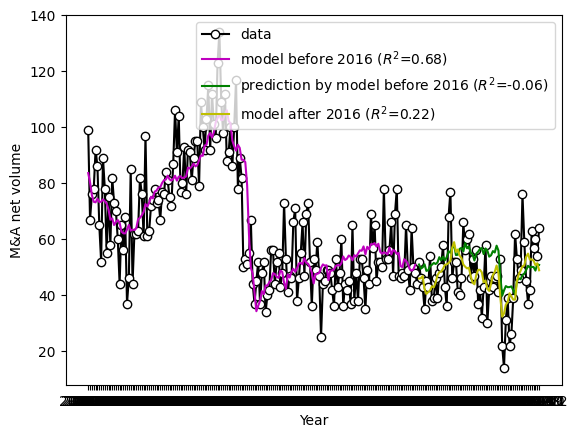

In [41]:
ax = plt.gca()

x_data = data.Date.astype(str)
ax.plot(x_data, data.vol, marker='o', color='k', mfc='white', ls='-', label='data')

Y_train_pred = model_before.predict(X_train)
x_data_before = data_before.index
r = r2_score(Y_train, Y_train_pred,)
ax.plot(x_data_before, Y_train_pred, color='m',
        label=f'model before 2016 ($R^2$={round(r, 2)})')

x_data_after = data_after.index
Y_test_pred = model_before.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='g',
        label=f'prediction by model before 2016 ($R^2$={round(r, 2)})')


"""Using model based on data before June.2016 to predict for 2016 - 2021"""
Y_test_pred = model_after.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='y',
        label=f'model after 2016 ($R^2$={round(r, 2)})')

# ax.axvline(65, ls='--', color='gray')
# plt.xticks(ticks=range(0, 89, 4), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
# ax.set_xlim(0, 88)
ax.set_ylabel('M&A net volume')
ax.set_xlabel('Year')
# ax.set_ylim(0, -500)
ax.legend(loc=0, frameon=True);

In [28]:
Y_test_pred_model_before = model_before.predict(X_test)
Y_test_pred_model_after = model_after.predict(X_test)

(array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  2.,  1.,  1.,  0.,  2.,  2.,  6.,  5.,  7.,  9.,  7.,  7.,
          5.,  7.,  1.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  1.,  3.,  3.,  2.,  2., 10.,  5.,  9.,  8.,
         10.,  6.,  2.,  3.]]),
 array([-1.85653918, -1.78157797, -1.70661676, -1.63165555, -1.55669434,
        -1.48173313, -1.40677192, -1.33181071, -1.2568495 , -1.1818883 ,
        -1.10692709, -1.03196588, -0.95700467, -0.88204346, -0.80708225,
        -0.73212104, -0.65715983, -0.58219862, -0.50723741, -0.4322762 ,
        -0.35731499, -0.28235378, -0.20739258, -0.13243137, -0.05747016,
         0.01749105,  0.09245226,  0.16741347,  0.24237468,  0.31733589,
         0.3922971 ]),
 <a list of 2 BarContainer objects>)

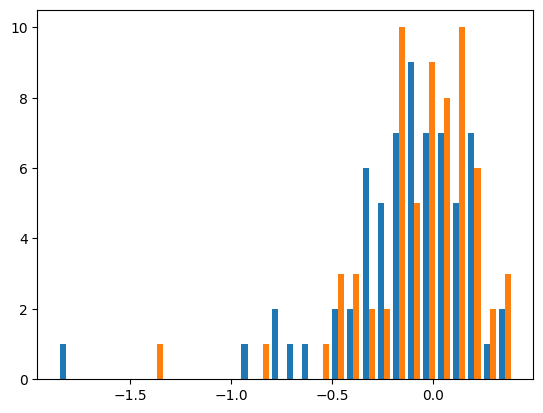

In [29]:
error_test_model_before = (Y_test - Y_test_pred_model_before) / Y_test
error_test_model_after = (Y_test - Y_test_pred_model_after) / Y_test
ax = plt.gca()

bins = np.linspace(-2, 0.5, 100)
plt.hist([error_test_model_before.reshape(-1), error_test_model_after.reshape(-1)], bins=30);

## Model before announcement of Brexit

In [42]:
"""Summary of model based on historical data before 2016"""
multi_model_before = sm.OLS(Y_train, X_train).fit()
multi_model_before.summary()
# """[X1:'EXUSUK', X2:'Interest_Rate', X3:'SMI', X4:'UK_GDP']"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     125.9
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           2.18e-43
Time:                        09:19:21   Log-Likelihood:                -697.06
No. Observations:                 178   AIC:                             1402.
Df Residuals:                     174   BIC:                             1415.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.8794     12.719      2.192      0.030       2.776      52.983
x1           -13.8760     10.871     -1.276      0.204     -35.333       7.581
x2             8.1607      0.701     11.644      0.000       6.777       9.544
x3             0.0351      0.006      5.834      0.000       0.023       0.047
==============================================================================
Omnibus:                        0.591   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.744   Jarque-Bera (JB):                0.286
Skew:                          -0.018   Prob(JB):                        0.867
Kurtosis:                       3.193   Cond. No.                     2.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1


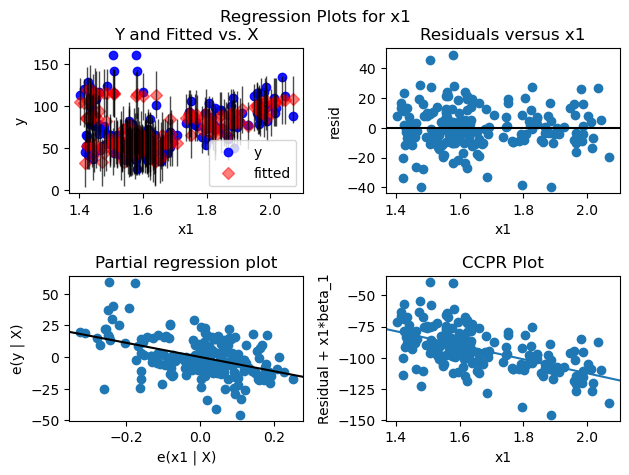

In [264]:
fig_before1 = sm.graphics.plot_regress_exog(multi_model_before, 1)

eval_env: 1


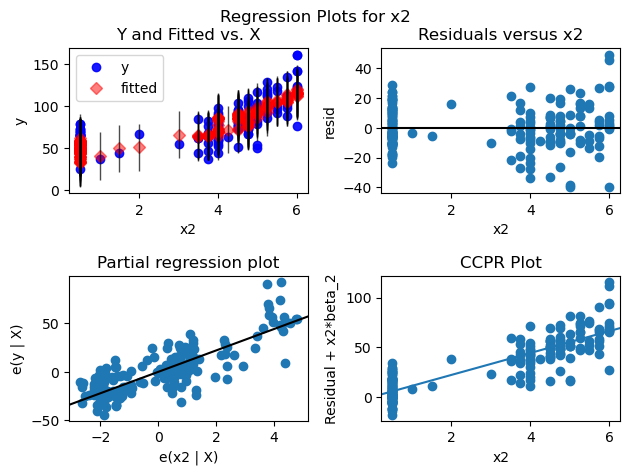

In [265]:
fig_before2 = sm.graphics.plot_regress_exog(multi_model_before, 2)

eval_env: 1


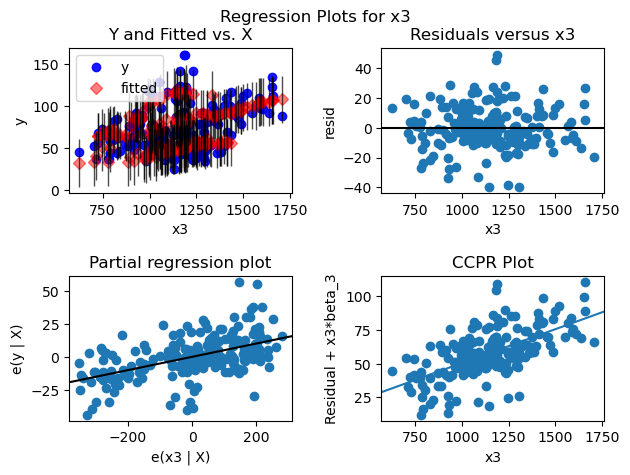

In [266]:
fig_before3 = sm.graphics.plot_regress_exog(multi_model_before, 3)

In [267]:
fig_before4 = sm.graphics.plot_regress_exog(multi_model_before, 4)

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

In [ ]:
print(multi_model_before.summary())
# ['EXUSUK', 'Interest_Rate', 'SMI', 'UK_GDP']

In [ ]:
sm.add_constant(X_train)

In [ ]:
multi_model_before.model.exog

In [43]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 4.897355720538671),
 ('p-value', 0.17946941852355586),
 ('f-value', 1.6409144584335205),
 ('f p-value', 0.18170058859969568)]

In [ ]:
VIF = [variance_inflation_factor(multi_model_before.model.exog, i) for i in range(1,5)]
VIF_data = pd.DataFrame(VIF, columns=['VIF'])
VIF_data.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data

## Model after announcement of Brexit

In [ ]:
multi_model_after = sm.OLS(Y_test, X_test).fit()
multi_model_after.summary()

In [ ]:
name_after = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_after = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name_after, test_after)

In [ ]:
VIF_after = [variance_inflation_factor(multi_model_after.model.exog, i) for i in range(1,5)]
VIF_data_after = pd.DataFrame(VIF_after, columns=['VIF'])
VIF_data_after.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_after

In [ ]:
fig_after1 = sm.graphics.plot_regress_exog(multi_model_after, 1)

In [ ]:
fig_after2 = sm.graphics.plot_regress_exog(multi_model_after, 2)

In [ ]:
fig_after3 = sm.graphics.plot_regress_exog(multi_model_after, 3)

In [ ]:
fig_after4 = sm.graphics.plot_regress_exog(multi_model_after, 4)

## Overall Model from 2000 to 2021

In [ ]:
X_all, Y_all = df_to_XY(gdp_quarter, xkeys=x_index, ykeys=y_index)
X_all = sm.add_constant(X_all)
overall_model_ols = sm.OLS(Y_all, X_all).fit()
overall_model_ols.summary()

In [ ]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(overall_model_ols.resid, overall_model_ols.model.exog)
lzip(name, test)

In [ ]:
VIF_overall = [variance_inflation_factor(overall_model_ols.model.exog, i) for i in range(1,5)]
VIF_data_over = pd.DataFrame(VIF_overall, columns=['VIF'])
VIF_data_over.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_over

In [ ]:
fig_overall1 = sm.graphics.plot_regress_exog(overall_model_ols, 1)

In [ ]:
fig_overall2 = sm.graphics.plot_regress_exog(overall_model_ols, 2)

In [ ]:
fig_overall3 = sm.graphics.plot_regress_exog(overall_model_ols, 3)

In [ ]:
fig_overall4 = sm.graphics.plot_regress_exog(overall_model_ols, 4)

In [ ]:
fig_before4 = sm.graphics.plot_regress_exog(multi_model_before, 4)

In [ ]:
print(multi_model_before.summary())
# ['EXUSUK', 'Interest_Rate', 'SMI', 'UK_GDP']

In [ ]:
sm.add_constant(X_train)

In [ ]:
multi_model_before.model.exog

In [ ]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name, test)

In [ ]:
VIF = [variance_inflation_factor(multi_model_before.model.exog, i) for i in range(1,5)]
VIF_data = pd.DataFrame(VIF, columns=['VIF'])
VIF_data.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data

## Model after announcement of Brexit

In [ ]:
multi_model_after = sm.OLS(Y_test, X_test).fit()
multi_model_after.summary()

In [ ]:
name_after = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_after = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name_after, test_after)

In [ ]:
VIF_after = [variance_inflation_factor(multi_model_after.model.exog, i) for i in range(1,5)]
VIF_data_after = pd.DataFrame(VIF_after, columns=['VIF'])
VIF_data_after.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_after

In [ ]:
fig_after1 = sm.graphics.plot_regress_exog(multi_model_after, 1)

In [ ]:
fig_after2 = sm.graphics.plot_regress_exog(multi_model_after, 2)

In [ ]:
fig_after3 = sm.graphics.plot_regress_exog(multi_model_after, 3)

In [ ]:
fig_after4 = sm.graphics.plot_regress_exog(multi_model_after, 4)

## Overall Model from 2000 to 2021

In [ ]:
X_all, Y_all = df_to_XY(gdp_quarter, xkeys=x_index, ykeys=y_index)
X_all = sm.add_constant(X_all)
overall_model_ols = sm.OLS(Y_all, X_all).fit()
overall_model_ols.summary()

In [ ]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(overall_model_ols.resid, overall_model_ols.model.exog)
lzip(name, test)

In [ ]:
VIF_overall = [variance_inflation_factor(overall_model_ols.model.exog, i) for i in range(1,5)]
VIF_data_over = pd.DataFrame(VIF_overall, columns=['VIF'])
VIF_data_over.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_over

In [ ]:
fig_overall1 = sm.graphics.plot_regress_exog(overall_model_ols, 1)

In [ ]:
fig_overall2 = sm.graphics.plot_regress_exog(overall_model_ols, 2)

In [ ]:
fig_overall3 = sm.graphics.plot_regress_exog(overall_model_ols, 3)

In [ ]:
fig_overall4 = sm.graphics.plot_regress_exog(overall_model_ols, 4)